In [1]:
import logging

import numpy as np
import dns.message, dns.query, dns.rdataclass, dns.rdatatype, dns.flags, dns.exception, dns.name
from tqdm import tqdm
from tranco import Tranco
import pandas as pd

In [5]:
IN = dns.rdataclass.from_text("IN")
NS = dns.rdatatype.from_text("NS")
AXFR = dns.rdatatype.from_text("AXFR")
DS = dns.rdatatype.from_text("DS")
DNSKEY = dns.rdatatype.from_text("DNSKEY")
SOA = dns.rdatatype.from_text("SOA")
DS = dns.rdatatype.from_text("DS")
A = dns.rdatatype.from_text("A")
AAAA = dns.rdatatype.from_text("AAAA")
RRSIG = dns.rdatatype.from_text("RRSIG")

In [6]:
def query(q, where='127.0.0.1', port=5301):
    logging.info(f'Query: {q.question[0].name} {dns.rdatatype.to_text(q.question[0].rdtype)}')
    q.flags = q.flags | dns.flags.CD
    try:
        r = dns.query.tcp(q, where=where, port=port, timeout=5)
    except dns.exception.Timeout:
        r = dns.query.tcp(q, where=where, port=port, timeout=5)
    logging.debug(f'Response Code: {r.rcode()}')
    logging.debug(f'Response: \n{r}')
    if r.rcode() == 2:  # servfail
        raise Exception(f"SERVFAIL after asking {q.question[0].name} {dns.rdatatype.to_text(q.question[0].rdtype)}")
    return r

In [4]:
def zone_soa(qname):
    while True: # loop over qname parents to query for SOA
        q = dns.message.make_query(qname, SOA, want_dnssec=True)
        r = query(q)
        if r.rcode() == 3:  # NXDOMAIN
            return None, None
        if r.rcode() != 0:
            raise Exception(f"zone_soa({qname}) query response code:{r.rcode()}")
        name = qname
        while True: # loop over qname parents to find SOA record in DNS reply
            rr = r.get_rrset(r.authority, name, IN, SOA) or r.get_rrset(r.answer, name, IN, SOA)
            rrsig = r.get_rrset(r.authority, name, IN, RRSIG, covers=SOA) or r.get_rrset(r.answer, name, IN, RRSIG, covers=SOA) or []
            if rr:
                return rr, rrsig
            logging.debug(f"getting parent of name {name}")
            if name == dns.name.root:
                break
            name = name.parent()
        logging.debug(f"getting parent of qname {qname}")
        qname = qname.parent()

def zone_ds(qname):
    q = dns.message.make_query(qname, DS)
    q.flags = q.flags | dns.flags.CD
    r = query(q)
    ds_set = r.get_rrset(r.answer, qname, IN, DS)
    return ds_set or []

def zone_dnskey(qname):
    q = dns.message.make_query(qname, DNSKEY, want_dnssec=True)
    q.flags = q.flags | dns.flags.CD
    r = query(q)
    dnskey_set = r.get_rrset(r.answer, qname, IN, DNSKEY) or []
    dnskey_set_rrsig = r.get_rrset(r.answer, qname, IN, RRSIG, covers=DNSKEY) or []
    return dnskey_set, dnskey_set_rrsig

In [10]:
%%bash
host lax.xfr.dns.icann.org

lax.xfr.dns.icann.org has address 192.0.32.132
lax.xfr.dns.icann.org has IPv6 address 2620:0:2d0:202::132


In [37]:
q = dns.message.make_query('.', AXFR, use_edns=0)
q.flags = q.flags | dns.flags.AD
print(q)

id 32709
opcode QUERY
rcode NOERROR
flags RD AD
edns 0
payload 1232
;QUESTION
. IN AXFR
;ANSWER
;AUTHORITY
;ADDITIONAL


In [42]:
import dns.xfr, dns.zone

In [59]:
domains = {
    rrset.name.to_text() 
    for m in dns.query.xfr('192.0.32.132', dns.name.root, timeout=5) 
    for rrset in m.answer + m.authority if rrset.rdtype in [NS]
}

In [60]:
len(domains)

1498

In [61]:
def check_domain(d):
    try:
        d = dns.name.from_text(d)
        soa, soa_rrsig = zone_soa(d)
        z = soa.name if soa else None
        
        if z is None:
            raise Exception(f"Could not identify zone name for domain {d}")
        
        ds = zone_ds(z)
        dnskey, dnskey_rrsig = (zone_dnskey(z)) if ds else ([], [])

        return {
            'domain': d.to_text(),
            'zone': z.to_text(),
            'soa_rrsig': soa_rrsig,
            'ds': ds,
            'dnskey': dnskey,
            'dnskey_rrsig': dnskey_rrsig,
        }
    except Exception as e:
        e.d = d.to_text()
        raise e

In [62]:
import concurrent

executor = concurrent.futures.ThreadPoolExecutor(50)

In [63]:
def run_queries(domains):
    errors = []
    results = []    
    futures = {d: executor.submit(check_domain, d) for d in tqdm(domains, desc="Scheduling queries")}
    with tqdm(total=len(futures), desc="Querying") as pbar:
        for future in concurrent.futures.as_completed(futures.values()):
            pbar.update(1)
            if future.exception():
                logging.warning(f"{future.exception().d}: {future.exception()}")
                errors.append(future.exception().d)
            else:
                results.append(future.result())
    return results, errors

In [64]:
results, errors = run_queries(domains)

Querying: 100%|██████████| 1498/1498 [00:07<00:00, 210.11it/s]


In [65]:
results_retry, errors_retry = run_queries(errors)

Scheduling queries: 0it [00:00, ?it/s]
Querying: 0it [00:00, ?it/s]


In [66]:
1 - len(errors_retry) / len(domains)

1.0

In [68]:
data = pd.DataFrame(results + results_retry)
data['ds_algos'] = data.apply(lambda row: {rr.algorithm for rr in row['ds']}, axis=1)
data['dnskey_algos'] = data.apply(lambda row: {rr.algorithm for rr in row['dnskey']}, axis=1)
data['dnskey_rrsig_algos'] = data.apply(lambda row: {rr.algorithm for rr in row['dnskey_rrsig']}, axis=1)
data['soa_rrsig_algos'] = data.apply(lambda row: {rr.algorithm for rr in row['soa_rrsig']}, axis=1)
data[data['ds'].apply(len) > 0].head(3)

,domain,zone,soa_rrsig,ds,dnskey,dnskey_rrsig,ds_algos,dnskey_algos,dnskey_rrsig_algos,soa_rrsig_algos
0,clinic.,clinic.,(SOA 8 1 3600 20211104123759 20211005113759 57...,(41947 8 2 b0f663276812153021d47e9cd2ff811528b...,(257 3 8 AwEAAcvTHmPn6v1yXm/FQhByRDSkM90A 8eX2...,(DNSKEY 8 1 3600 20211103211720 20211004211304...,{Algorithm.RSASHA256},{Algorithm.RSASHA256},{Algorithm.RSASHA256},{Algorithm.RSASHA256}
1,chat.,chat.,(SOA 8 1 3600 20211104123811 20211005113811 55...,(26920 8 1 b173a1003fa332b416e206ab573f01f37ca...,(256 3 8 AwEAAcbmk/5OptWsFOhli3ZKoPH/T/08 J6gS...,(DNSKEY 8 1 3600 20211103212813 20211004210431...,{Algorithm.RSASHA256},{Algorithm.RSASHA256},{Algorithm.RSASHA256},{Algorithm.RSASHA256}
2,ua.,ua.,(SOA 13 1 36036 20211104113100 20211005113100 ...,(48349 13 2 d8456df0eab0db7d2422b4110722f5772d...,(257 3 13 C2bE7DeaYbO2Am+P1gdNZfkPEyxILzG1 cB7...,(DNSKEY 13 1 36036 20211104083100 202110050831...,{Algorithm.ECDSAP256SHA256},{Algorithm.ECDSAP256SHA256},{Algorithm.ECDSAP256SHA256},{Algorithm.ECDSAP256SHA256}


In [70]:
data['dnskey_rrsig_ok'] = data.apply(lambda row: row['dnskey_rrsig_algos'].issuperset(row['ds_algos']), axis=1)
data['soa_rrsig_ok'] = data.apply(lambda row: row['soa_rrsig_algos'].issuperset(row['dnskey_algos']), axis=1)

In [71]:
data['dnskey_rrsig_ok'].mean(), data['soa_rrsig_ok'].mean()

(0.9973297730307076, 0.9973297730307076)

In [72]:
(~data['dnskey_rrsig_ok']).sum(), (~data['soa_rrsig_ok']).sum()

(4, 4)

In [79]:
data[~data['dnskey_rrsig_ok'] | ~data['dnskey_rrsig_ok']][['zone', 'ds_algos', 'dnskey_rrsig_algos', 'dnskey_rrsig_ok', 'dnskey_algos', 'soa_rrsig_algos', 'soa_rrsig_ok']]

,zone,ds_algos,dnskey_rrsig_algos,dnskey_rrsig_ok,dnskey_algos,soa_rrsig_algos,soa_rrsig_ok
434,sex.,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False
647,xxx.,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False
1463,porn.,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False
1486,adult.,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False,"{Algorithm.RSASHA256, Algorithm.RSASHA1NSEC3SHA1}",{Algorithm.RSASHA256},False


In [80]:
data['dangling_ds_algo'] = data.apply(lambda row: row['ds_algos'] - row['dnskey_rrsig_algos'], axis=1)

In [81]:
data['dangling_dnskey_algo'] = data.apply(lambda row: row['dnskey_algos'] - row['soa_rrsig_algos'], axis=1)

In [82]:
dangling, counts = np.unique(data['dangling_ds_algo'], return_counts=True)
hist = {}
for algos, num in zip([tuple(sorted(d)) for d in dangling], counts):
    hist[algos] = hist.get(algos, 0) + num
hist

{(): 1494, (<Algorithm.RSASHA1NSEC3SHA1: 7>,): 4}

In [83]:
dangling, counts = np.unique(data['dangling_dnskey_algo'], return_counts=True)
hist = {}
for algos, num in zip([tuple(sorted(d)) for d in dangling], counts):
    hist[algos] = hist.get(algos, 0) + num
hist

{(): 1494, (<Algorithm.RSASHA1NSEC3SHA1: 7>,): 4}

In [85]:
data.to_pickle(f'dnssec-misconfiguration-prevalence-tld.pickle')

In [102]:
import numpy as np

In [107]:
list(zip(*np.unique(data['ds_algos'].apply(lambda x: tuple(sorted(x))), return_counts=True)))

[((), 126),
 ((<Algorithm.RSASHA1: 5>,), 29),
 ((<Algorithm.RSASHA1NSEC3SHA1: 7>,), 34),
 ((<Algorithm.RSASHA1NSEC3SHA1: 7>, <Algorithm.RSASHA256: 8>), 4),
 ((<Algorithm.RSASHA256: 8>,), 1227),
 ((<Algorithm.RSASHA512: 10>,), 33),
 ((<Algorithm.ECDSAP256SHA256: 13>,), 45)]

In [88]:
import seaborn as sns

<AxesSubplot:xlabel='ds_algos_short', ylabel='Count'>

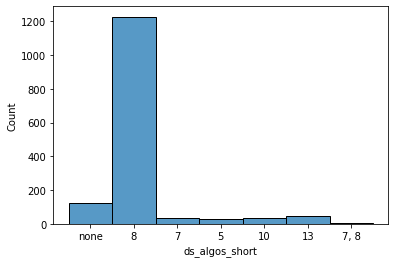

In [109]:
data['ds_algos_short'] = data.apply(lambda row: ', '.join(sorted(str(int(a)) for a in row['ds_algos'])) or 'none', axis=1)
sns.histplot(
    data=data.sort_values('ds_algos'),
    x='ds_algos_short',
)

# Debug

In [ ]:
logging.basicConfig(level=logging.DEBUG, force=True)

In [ ]:
zone_dnskey(dns.name.from_text('europa.eu'))